#### Go to https://pytorch.org/ and follow the instructions to install PyTorch.

## Imports

In [23]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


from IPython.display import Image, display, clear_output
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
%matplotlib inline

# get rid of uninteresting warning
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

## Import dataset

In [24]:
path = Path().cwd()

data_file = path / "zipdata.mat"
data = scipy.io.loadmat(data_file)

X_train, X_test, y_train, y_test = train_test_split(data['X'], data['y'], test_size=0.33, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)
classes = [0,1,2,3,4,5,6,7,8,9]

### setup loaders

In [25]:
BATCH_SIZE = 67
EPOCH = 10000

train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

test_dataset = Data.TensorDataset(X_test, y_test)
test_loader = Data.DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

## Artificial Neural Network

In [26]:
class AutoEncoderNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden_features, latent_features):
        super(AutoEncoderNet, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(n_feature, n_hidden_features),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden_features, latent_features)
          )   
        
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_features, n_hidden_features),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden_features, n_feature)
        )

    def forward(self, x):
        latent_space = self.encoder(x)

        x_reconstruction = self.decoder(latent_space)
        
        
        return latent_space, x_reconstruction
    
number_of_features = 256
n_hidden_features = 20
latent_features = 10
learning_rate = 0.01
# L2 Regularization is added to the optimizer as weight decay, use a number between 0 and 1
# If more regularization is desired then you can add dropout to the network 
weight_decay = 0.0
    
aenet = AutoEncoderNet(n_feature=number_of_features, n_hidden_features=n_hidden_features, latent_features=latent_features)     # define the network
print(aenet)  # net architecture
optimizer = torch.optim.Adam(aenet.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_func = torch.nn.MSELoss()  # MSE loss function

AutoEncoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=256, bias=True)
  )
)


## Early stopping

In [27]:
# from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d

class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.bestModel = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics, curmodel):
        if self.best is None:
            self.best = metrics
            self.bestModel = curmodel
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
            self.bestModel = curmodel
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)
                

                
# play around with patience
# The early stopping module takes in the following parameters
# mode='min' / 'max' - whether smaller or lager is better
# min_delta=0 - a delta that can be used to be more lenient when evaulating "bad" epochs
# patience=10 - how many "bad" epochs that are allowed(epoches with worse score than the current best)
# percentage=False / True - whether the criterion is in percentage or not
earlyStopping = EarlyStopping(patience=5)

### 3)  Try compressing the zip data with an autoencoder. The weights in the encoder represents the pattern used in each latent variable: 

Stopping early
Finished Training


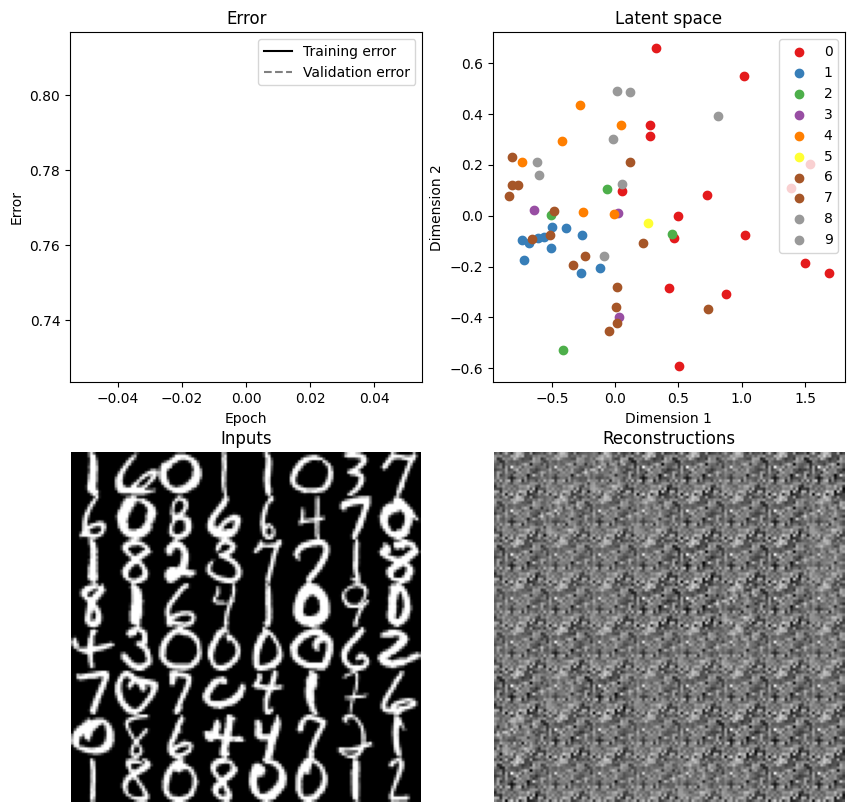

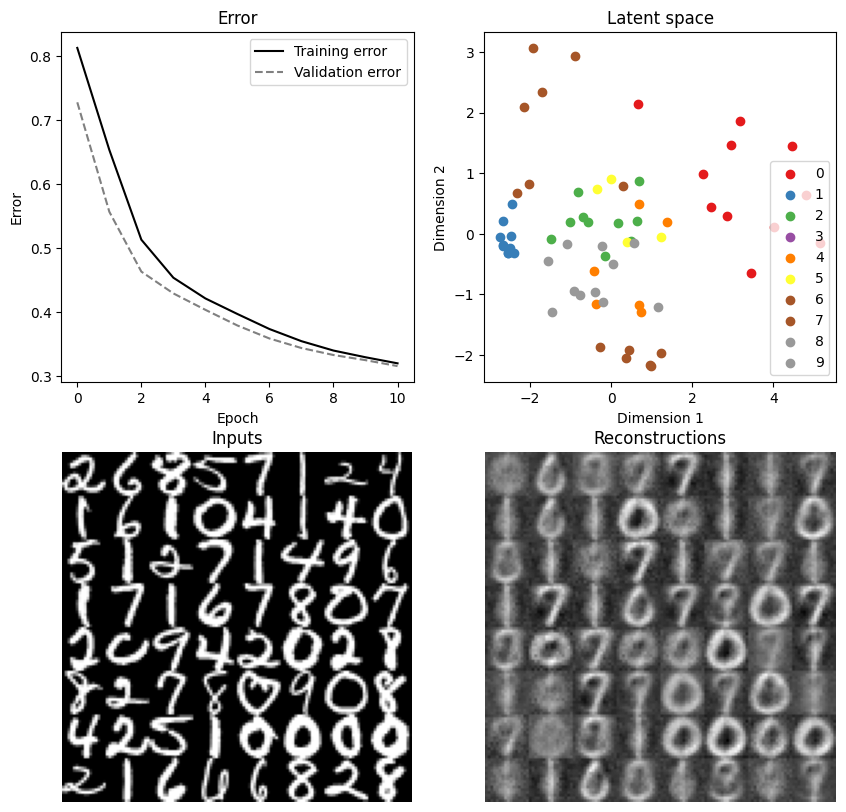

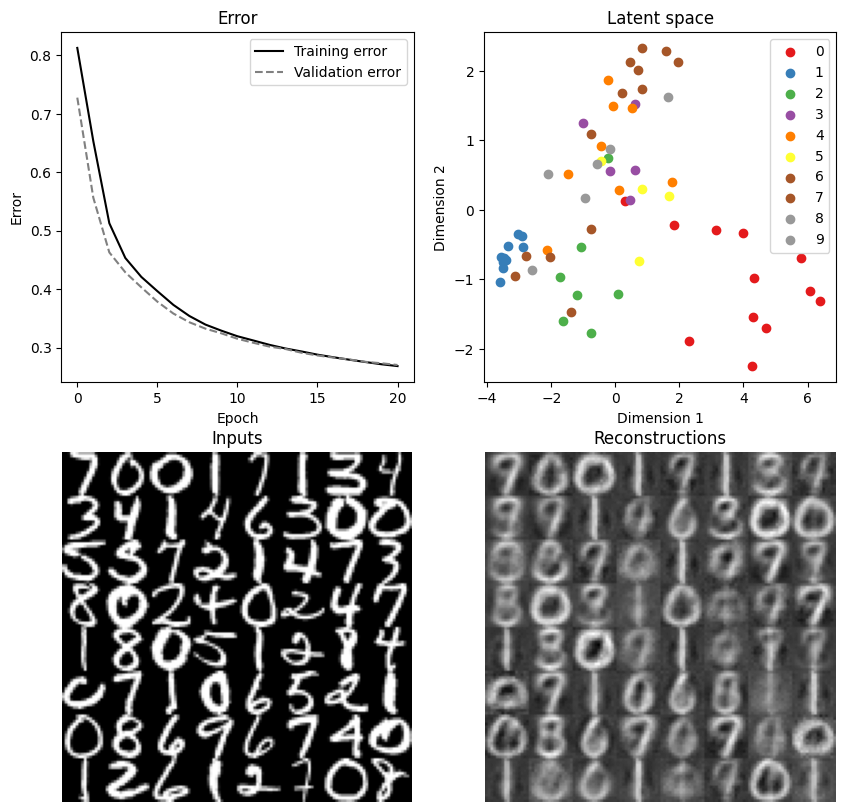

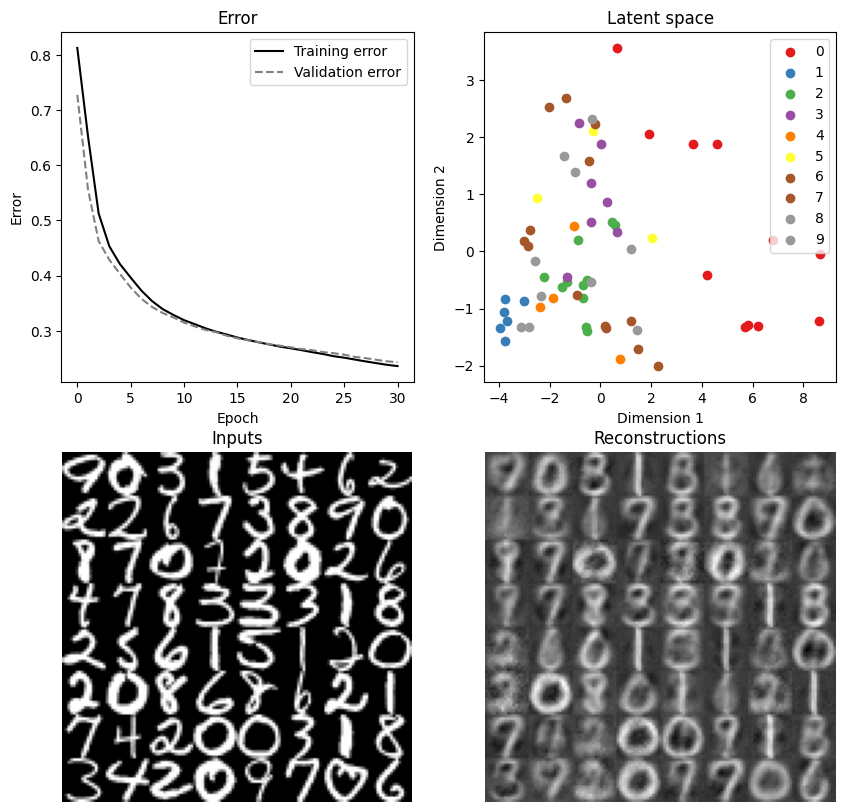

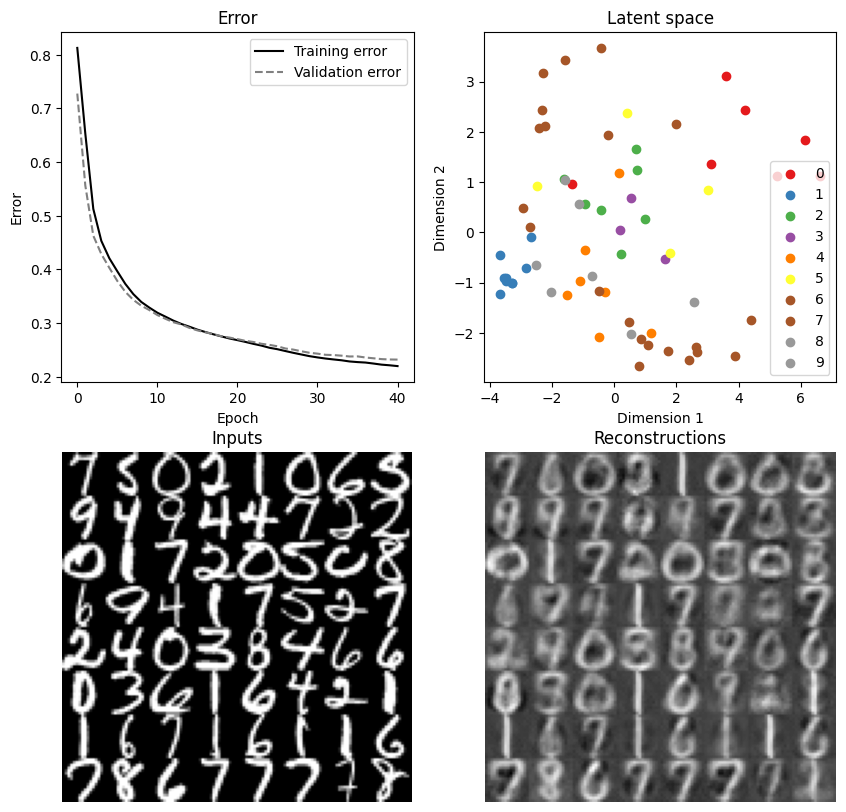

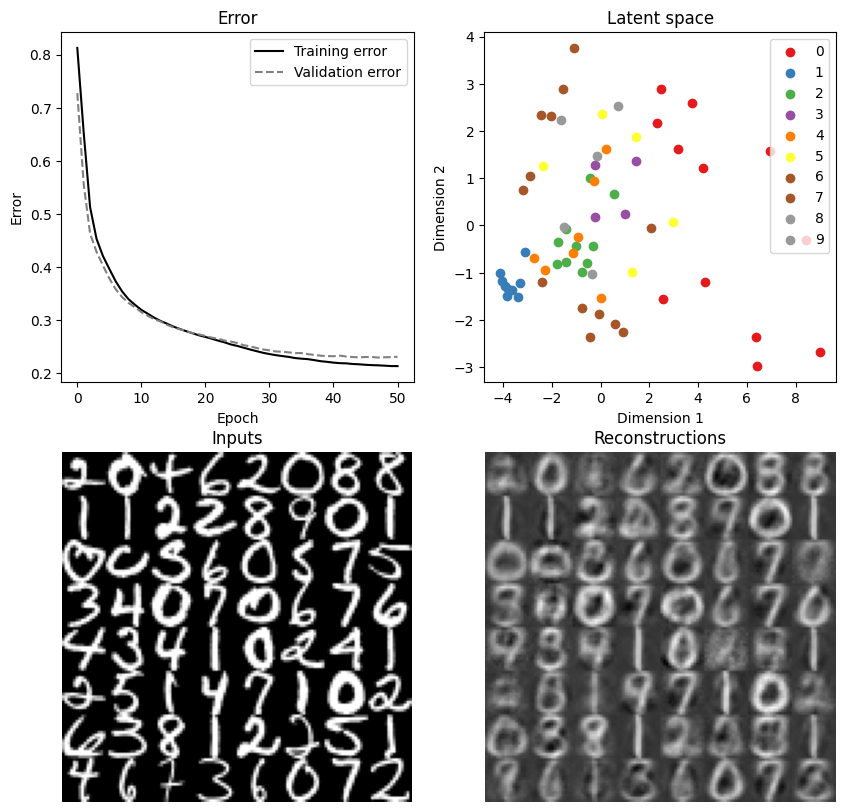

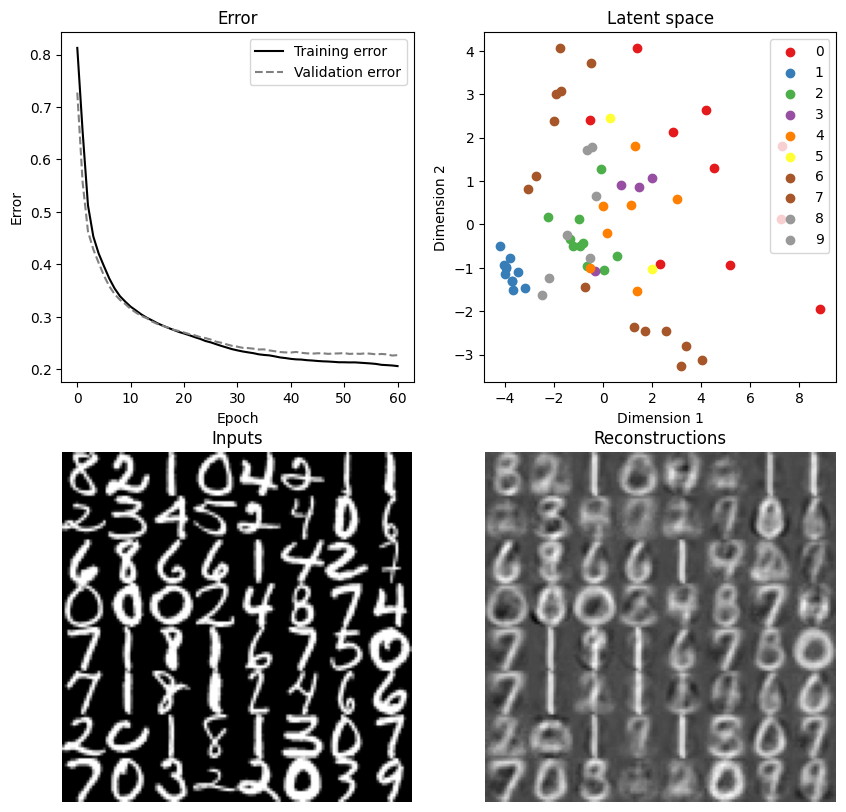

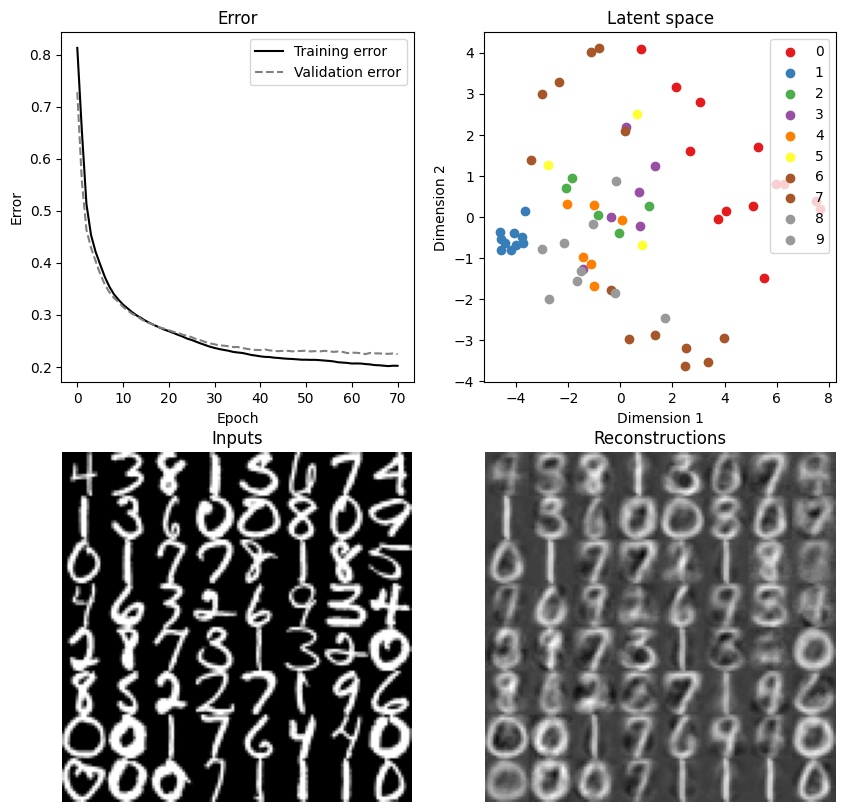

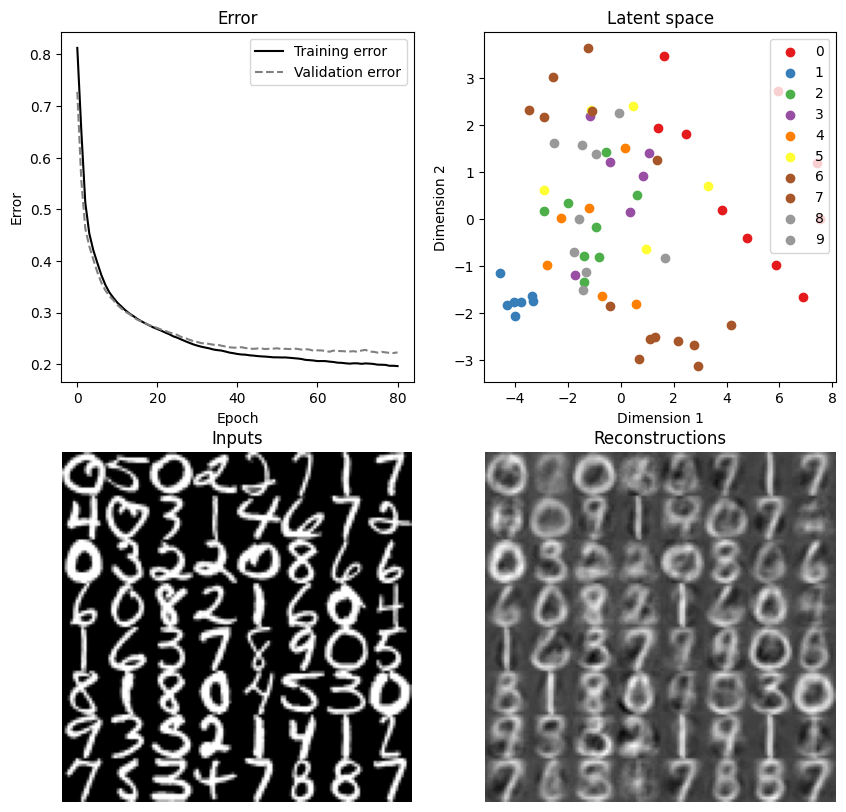

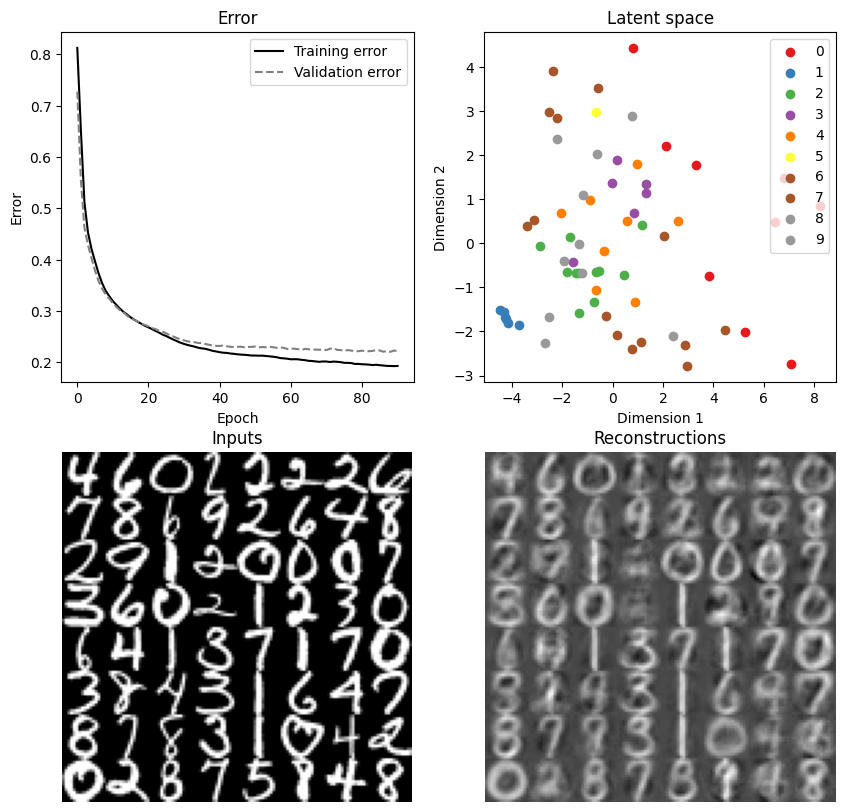

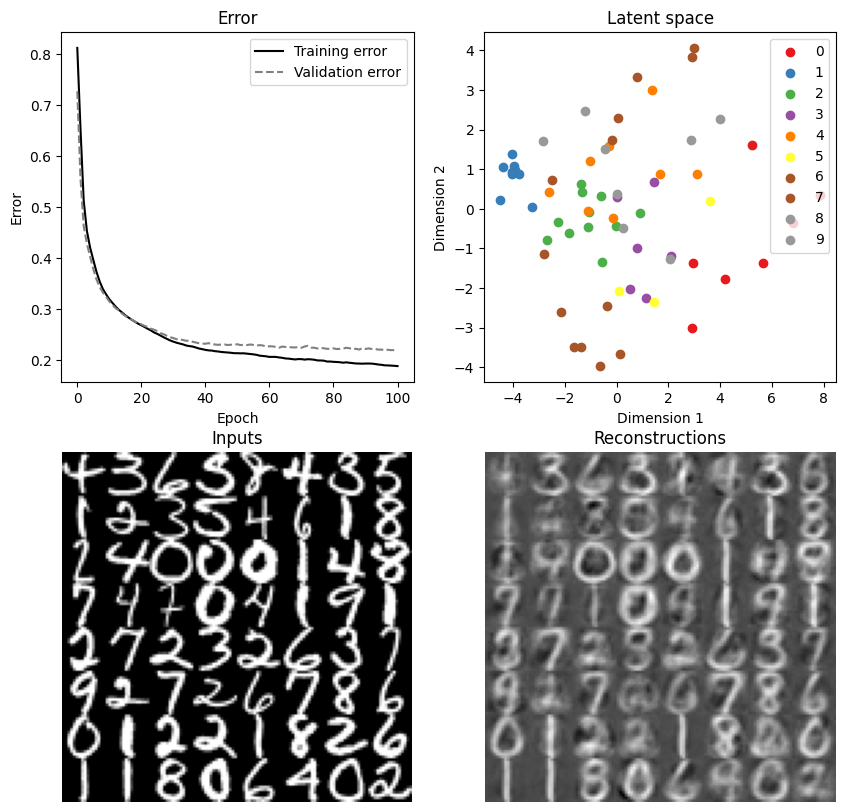

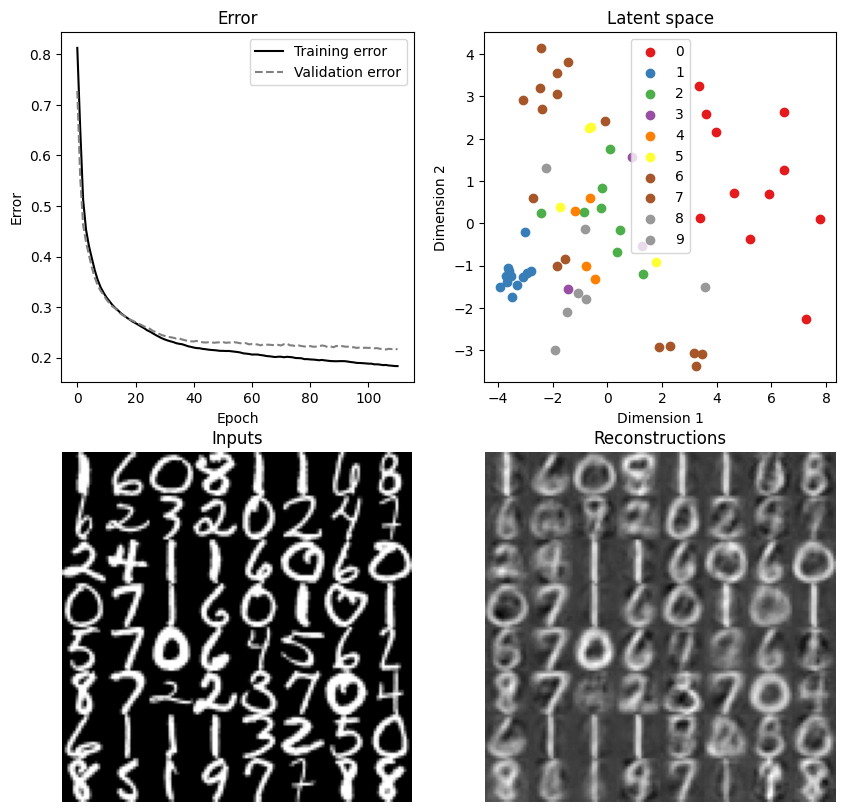

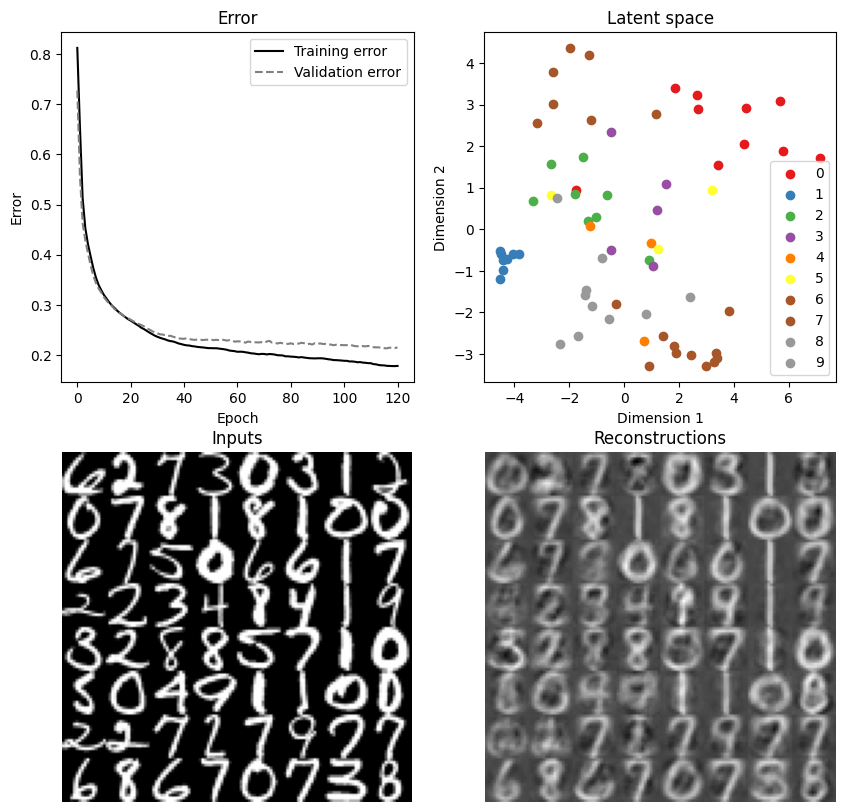

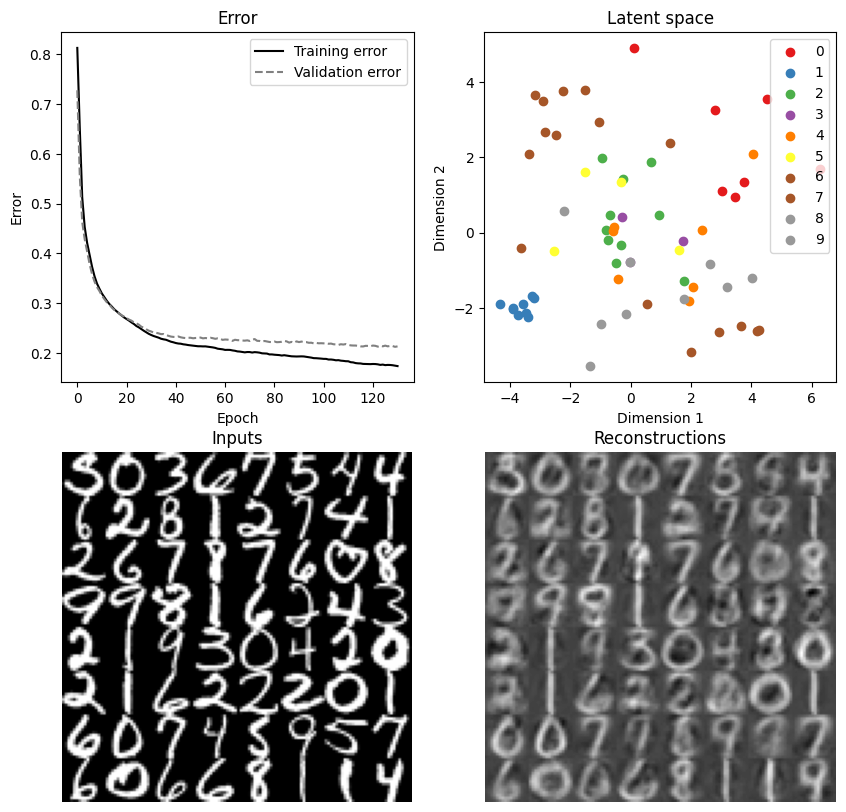

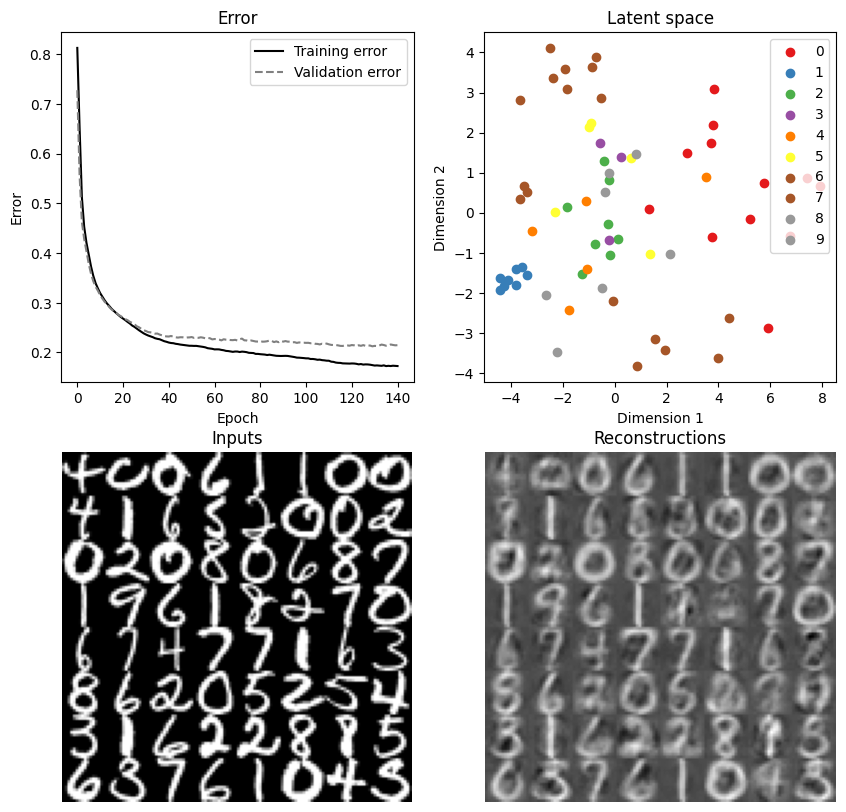

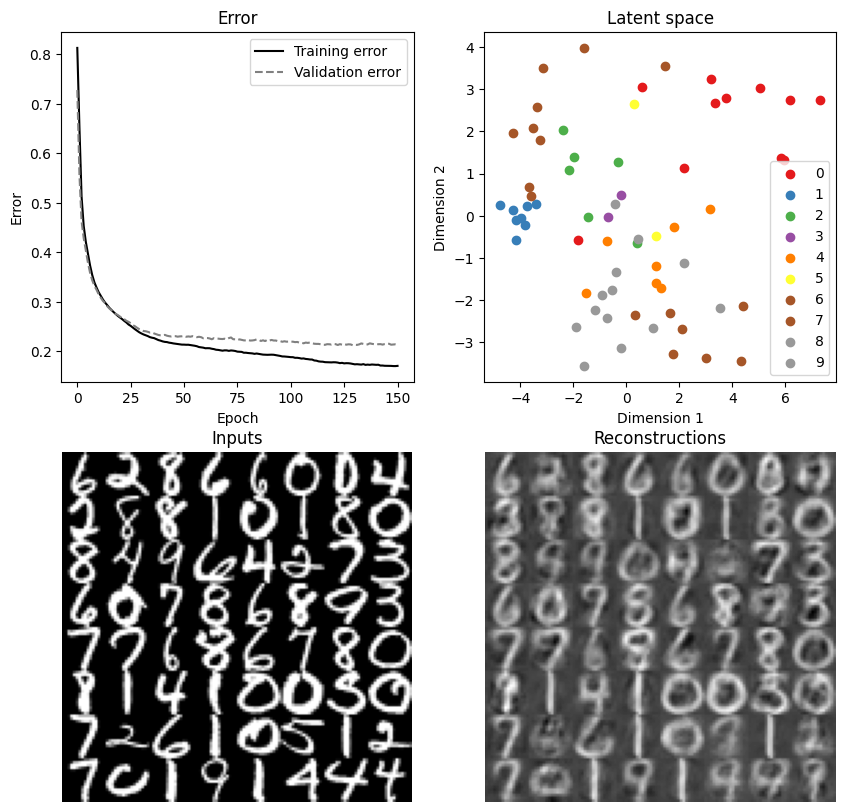

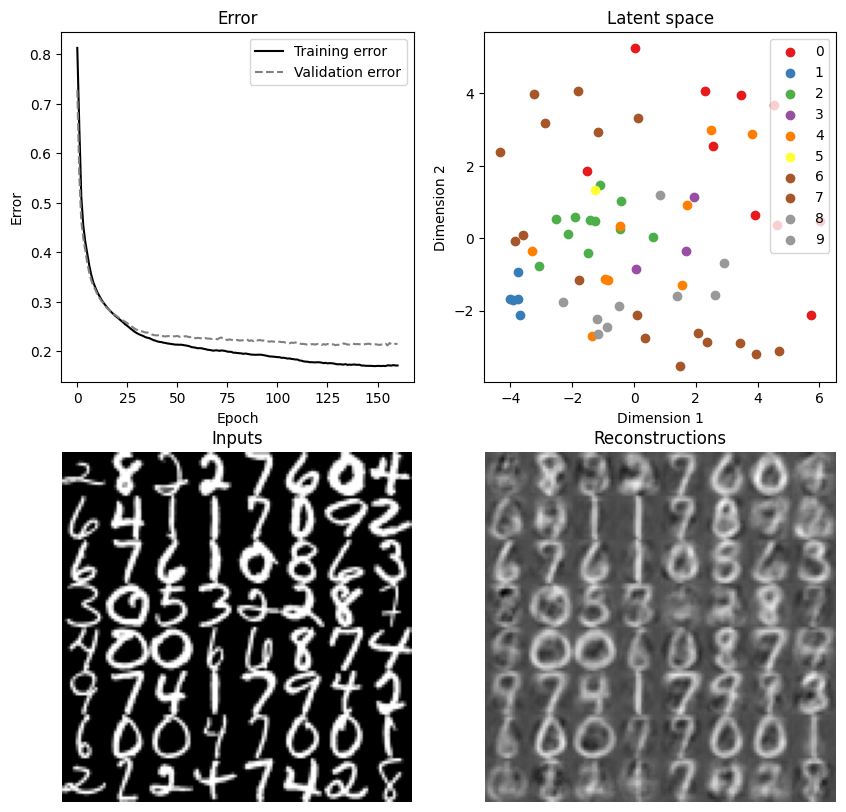

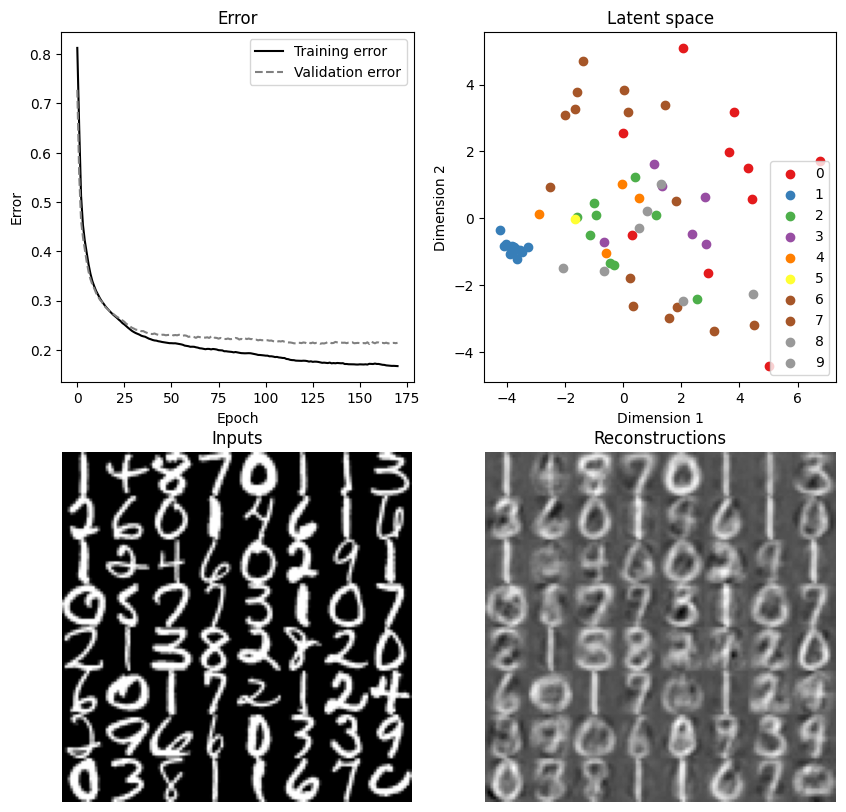

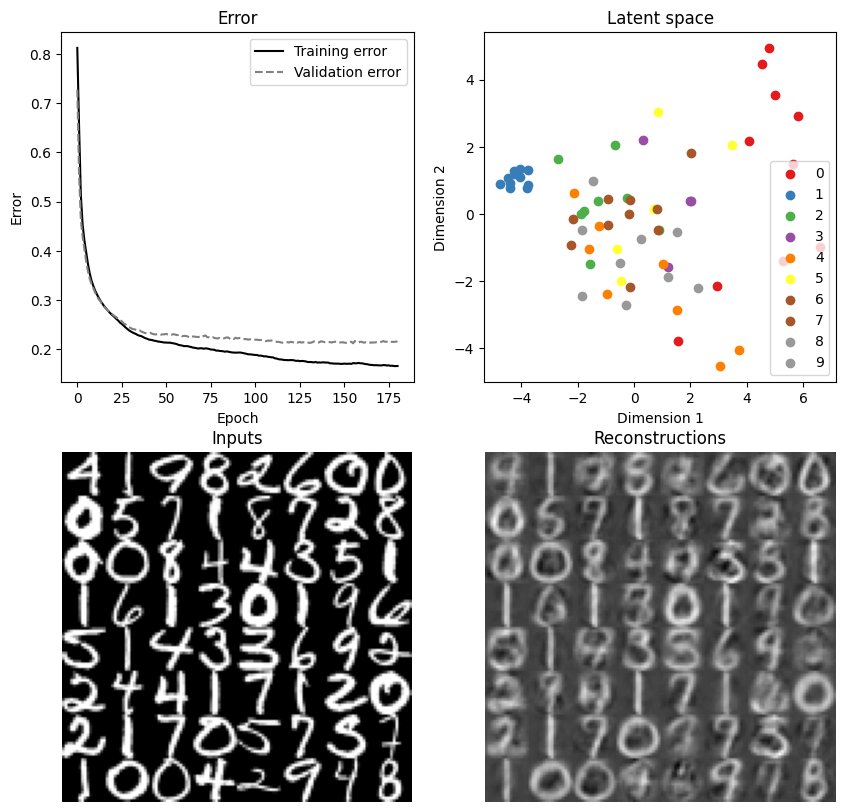

In [28]:

# train the neural network

average_test_loss=[]
average_train_loss=[]
for epoch in range(EPOCH):  # loop over the dataset multiple times
    
    train_loss_graph = 0
    aenet.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        xtrain, ytrain = data

        # forward + backward + optimize
        latent_space, x_reconstruction = aenet(xtrain)

        loss = loss_func(x_reconstruction, xtrain)
        train_loss_graph += loss.item() * xtrain.shape[0] #Multiply with the current batchsize to get pr. sample loss
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    
    # testing
    test_loss_graph  = 0
    with torch.no_grad():
        aenet.eval()
        for data in test_loader:
            xtest, ytest = data
            latent_space, x_reconstruction = aenet(xtest)
            loss = loss_func(x_reconstruction, xtest)
            test_loss_graph += loss.item() * xtest.shape[0] #Multiply with the current batchsize to get pr. sample loss


    average_train_loss.append(train_loss_graph/len(train_dataset))
    average_test_loss.append(test_loss_graph/len(test_dataset))

    # plotting code from dtu deep learning course
    if epoch % 10 == 0:
        f, axarr = plt.subplots(2, 2, figsize=(10, 10))
        ax = axarr[0, 0]
        ax.set_title("Error")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Error')


        ax.plot(np.arange(epoch+1), average_train_loss, color="black")
        ax.plot(np.arange(epoch+1), average_test_loss, color="gray", linestyle="--")
        ax.legend(['Training error', 'Validation error'])

        # Latent space
        ax = axarr[0, 1]

        ax.set_title('Latent space')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')

        # If you want to use a dimensionality reduction method you can use
        # for example PCA by projecting on two principal dimensions
        latent_space = PCA(n_components=2).fit_transform(latent_space)

        colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
        for c in classes:
            ax.scatter(*latent_space[ytest.numpy().squeeze() == c].T, color=next(colors), marker='o')

        ax.legend(classes)

        # Inputs
        ax = axarr[1, 0]
        ax.set_title('Inputs')
        ax.axis('off')

        rows = 8
        columns = BATCH_SIZE // rows

        canvas = np.zeros((16*rows, columns*16))
        for i in range(rows):
            for j in range(columns):
                idx = i % columns + rows * j
                canvas[i*16:(i+1)*16, j*16:(j+1)*16] = xtest[idx].reshape((16, 16))
        ax.imshow(canvas, cmap='gray')


        # Reconstructions
        ax = axarr[1, 1]
        ax.set_title('Reconstructions')
        ax.axis('off')

        canvas = np.zeros((16*rows, columns*16))
        for i in range(rows):
            for j in range(columns):
                idx = i % columns + rows * j
                canvas[i*16:(i+1)*16, j*16:(j+1)*16] = x_reconstruction[idx].reshape((16, 16))


        ax.imshow(canvas, cmap='gray')
        f.canvas.draw()       # draw the canvas, cache the renderer
        # Early stopping
        if earlyStopping.step(torch.tensor(test_loss_graph/len(test_dataset)),aenet):
            print ("Stopping early")
            aenet = earlyStopping.bestModel
            break

print('Finished Training')